# Loading Libraries & Data

In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")


import tensorflow as tf
import os
from tensorflow.keras import layers, models
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import plotly.express as px
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
data = pd.read_csv("../input/natural-gas-price-data/ngpf_data.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6321 entries, 0 to 6320
Data columns (total 2 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Day                               6321 non-null   object 
 1   Price in Dollars per Million Btu  6320 non-null   float64
dtypes: float64(1), object(1)
memory usage: 98.9+ KB


# Data Preparation

In [3]:
data['Day'] = pd.to_datetime(data['Day'], format = "%d/%m/%Y")
data.head(3)

,Day,Price in Dollars per Million Btu
0,2022-03-01,4.36
1,2022-02-28,4.46
2,2022-02-25,4.63


In [4]:
data.tail(3)

,Day,Price in Dollars per Million Btu
6318,1997-01-09,3.61
6319,1997-01-08,3.80
6320,1997-01-07,3.82


> Data is from 7 Jan 1997 to 1 March 2022 with 6321 records.

In [5]:
# Renaming columns
data = data.rename({'Day': 'date', 'Price in Dollars per Million Btu': 'gas_price'}, axis = 1)

# Setting Date as index
data = data.set_index('date')

In [6]:
data.tail(3)

,gas_price
date,
1997-01-09,3.61
1997-01-08,3.80
1997-01-07,3.82


# Exploratory Data Analysis

### 1. Missing Values

In [7]:
print(data.isnull().sum())

gas_price    1
dtype: int64


In [8]:
# There is one missing value in the data, we fill it with previous day's price.

data = data.fillna(method = 'pad')
print(data.isnull().sum())

gas_price    0
dtype: int64


### 2. Line Chart

In [9]:
fig = px.line(data, title = 'Natural Gas Spot Prices', template = 'plotly_dark')
fig.show()

### 3. Histogram

In [10]:
fig = px.histogram(data, x = "gas_price", template = 'plotly_dark')
fig.show()

### 4. Check if a Time Series is Stationary or Not

> A TS is said to be stationary if its statistical properties such as mean, variance remain constant over time.

> 2 methods to check stationary time series: Plotting Rolling Stats & Dickey - Fuller Test.

> Null Hypothesis: TS is non-Stationary

In [11]:
def test_stationarity(timeseries):
    
    # Determing rolling statistics
    rolmean = timeseries.rolling(25).mean()
    rolstd = timeseries.rolling(25).std()

    # Plot rolling statistics:
    plt.figure(figsize = (20,10))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
        
    print(dfoutput)

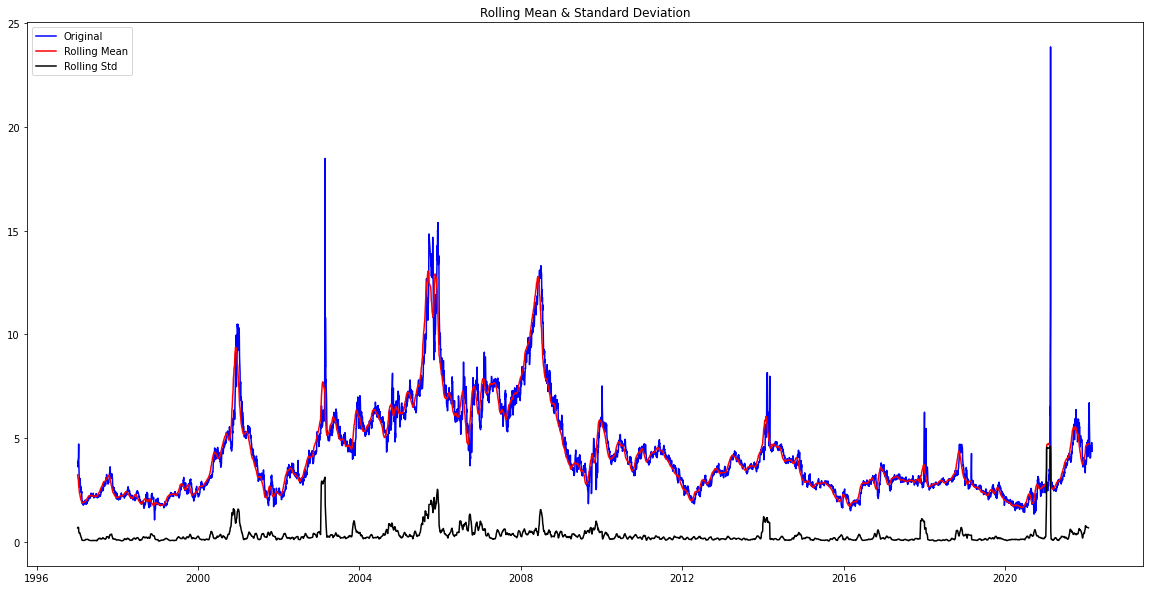

Results of Dickey-Fuller Test:
Test Statistic                   -3.867920
p-value                           0.002284
#Lags Used                        8.000000
Number of Observations Used    6312.000000
Critical Value (1%)              -3.431386
Critical Value (5%)              -2.861998
Critical Value (10%)             -2.567014
dtype: float64


In [12]:
test_stationarity(data)

> Test Statistics shows how closely your observed data match the distribution expected under the null hypothesis of that statistical test.

> Test Statistic < Critical Value & p-value < 0.05. Hence we reject the Null Hypothesis.

> Data is Stationary.

> However, There are 2 major reasons behind non-stationaruty of a TS:

>> 1. Trend – Varying mean over time. 

>> 2. Seasonality – Variations at specific time-frames. 

> If TS is non-stationary: Estimate the trend and seasonality in the ts and remove it.

> Final step: To convert the forecasted values into the original scale by applying trend and seasonality constraints back.

> More less test statistic value more trend in pattern.

### 5. Estimating and Eliminating Trends

> Simple Trend Reduction Techniques: Moving Average and Exponential Weighted Moving Average. 

> The simple trend reduction techniques don’t work with high seasonality. There we use following methods.

>> 1. Differencing – Taking the difference with a particular Time Lag. Subtracting Current observation from previous.

>> 2. Decomposition – Modeling both trend and seasonality and removing them from the model. Residuals of LR. Additive Dec.

#### Exponential Weighted Moving Average

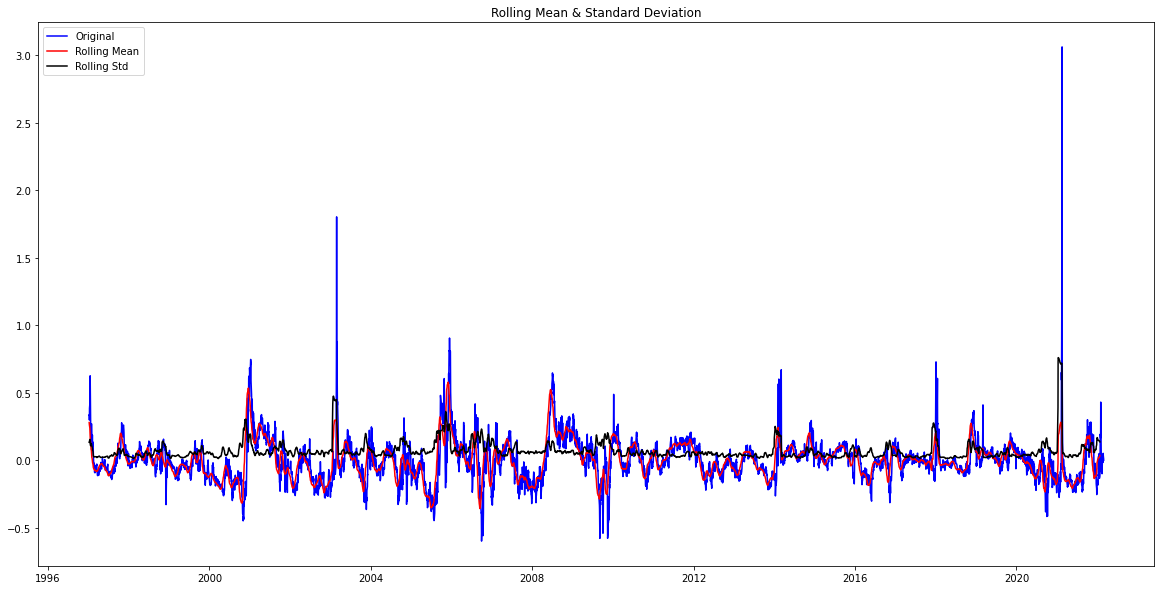

Results of Dickey-Fuller Test:
Test Statistic                -1.125358e+01
p-value                        1.688509e-20
#Lags Used                     1.000000e+01
Number of Observations Used    6.310000e+03
Critical Value (1%)           -3.431387e+00
Critical Value (5%)           -2.861998e+00
Critical Value (10%)          -2.567014e+00
dtype: float64


In [13]:
ts_sqrt = np.sqrt(data)
expwighted_avg = ts_sqrt.ewm(halflife = 25).mean()

ts_sqrt_ewma_diff = ts_sqrt - expwighted_avg
test_stationarity(ts_sqrt_ewma_diff)

#### Differencing

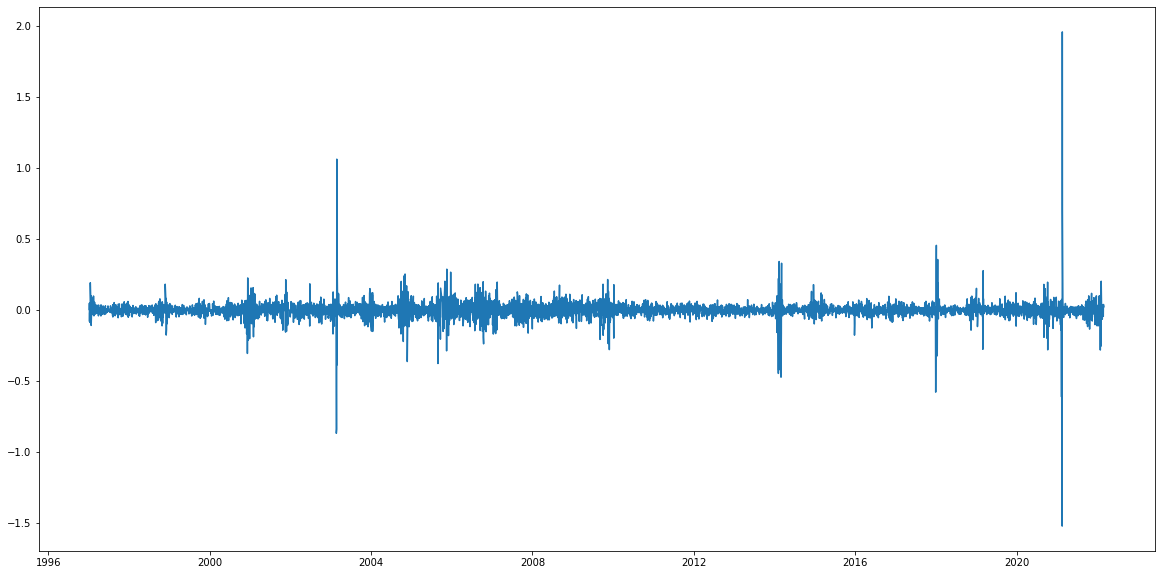

In [14]:
ts_sqrt_diff = ts_sqrt - ts_sqrt.shift()

plt.figure(figsize = (20,10))
plt.plot(ts_sqrt_diff)
plt.show()

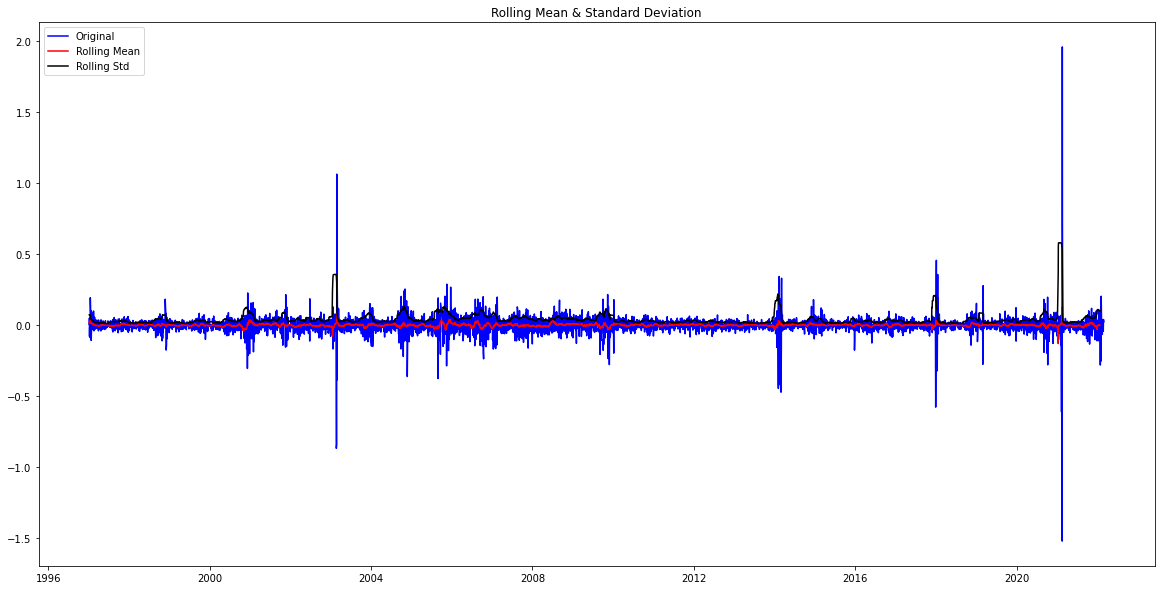

Results of Dickey-Fuller Test:
Test Statistic                  -25.917790
p-value                           0.000000
#Lags Used                       11.000000
Number of Observations Used    6308.000000
Critical Value (1%)              -3.431387
Critical Value (5%)              -2.861998
Critical Value (10%)             -2.567014
dtype: float64


In [15]:
ts_sqrt = np.sqrt(data)
ts_sqrt_diff = ts_sqrt - ts_sqrt.shift()
ts_sqrt_diff.dropna(inplace = True)
test_stationarity(ts_sqrt_diff)

> Test Statistic < Critical Value and also there is less diversion in mean and std. This is perfect stationary ts.

# Data Modeling

### Train Test Split

In [16]:
data = data.sort_values(by = 'date')

train = data['1997-01-06': '2020-01-06'] # 7 Jan 1997 to 6 Jan 2021 
test = data['2020-01-07': '2022-03-01'] # 7 Jan 2021  to 1 Mar 2022 

print("Length of Train Data: ", len(train))
print("Length of Test Data: ", len(test))

Length of Train Data:  5783
Length of Test Data:  538


In [17]:
train.head(2)

,gas_price
date,
1997-01-07,3.82
1997-01-08,3.80


In [18]:
train.tail(2)

,gas_price
date,
2020-01-03,2.06
2020-01-06,2.10


In [19]:
test.head(2)

,gas_price
date,
2020-01-07,2.17
2020-01-08,2.09


In [20]:
test.tail(2)

,gas_price
date,
2022-02-28,4.46
2022-03-01,4.36


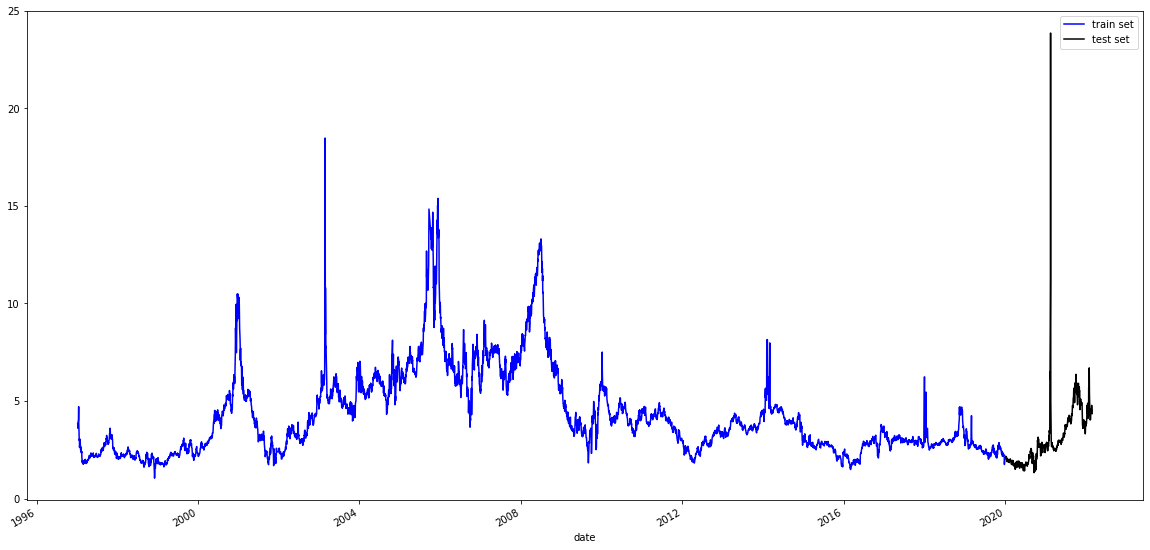

In [21]:
ax = train.plot(figsize = (20, 10), color = 'b')
test.plot(ax = ax, color = 'black')
plt.legend(['train set', 'test set'])
plt.show()

### Arima: Auto Regressive Integrated Moving Average

> Is actually a class of models that ‘explains’ a given time series based on its own past values, that is, its own lags and the lagged forecast errors, so that equation can be used to forecast future values.

>

> Prerequisite: Data must be stationary.

> An ARIMA model is characterized by 3 terms: p: order of the AR term , q: MA term, d is the number of differencing required to make the time series stationary.



#### Finding d: Number of differences required.

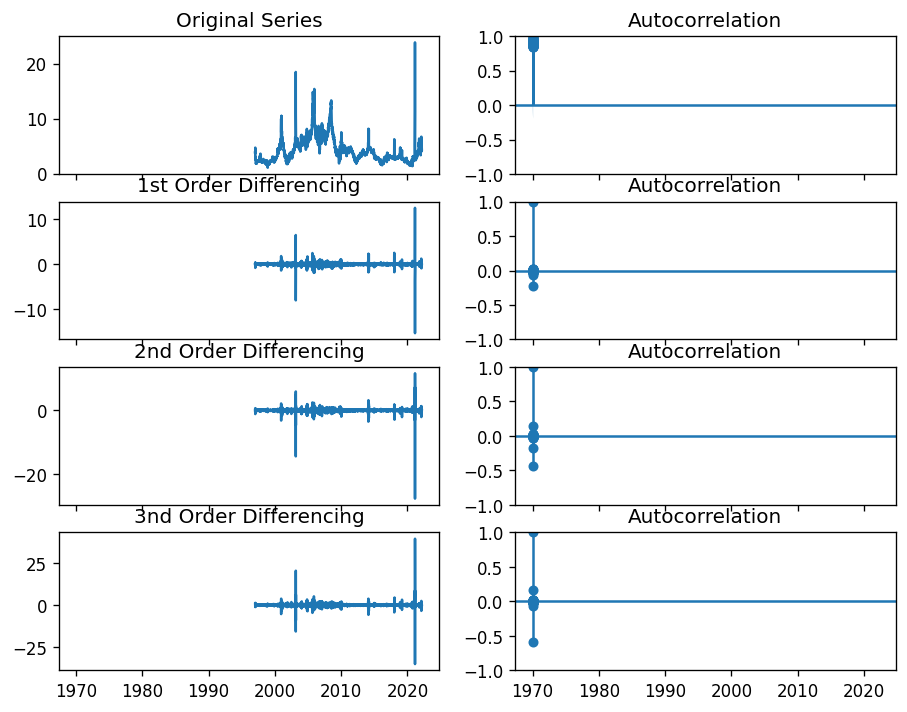

In [22]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(4, 2, sharex=True)
axes[0, 0].plot(data.gas_price); axes[0, 0].set_title('Original Series')
plot_acf(data.gas_price, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(data.gas_price.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(data.gas_price.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(data.gas_price.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(data.gas_price.diff().diff().dropna(), ax=axes[2, 1])

# 3rd Differencing
axes[3, 0].plot(data.gas_price.diff().diff().diff()); axes[3, 0].set_title('3nd Order Differencing')
plot_acf(data.gas_price.diff().diff().diff().dropna(), ax=axes[3, 1])

plt.show()

#### Finding order of AR term (p)

> We will find out the required number of AR terms by inspecting the Partial Autocorrelation (PACF) plot.
>
> Partial autocorrelation can be imagined as the correlation between the series and its lag.

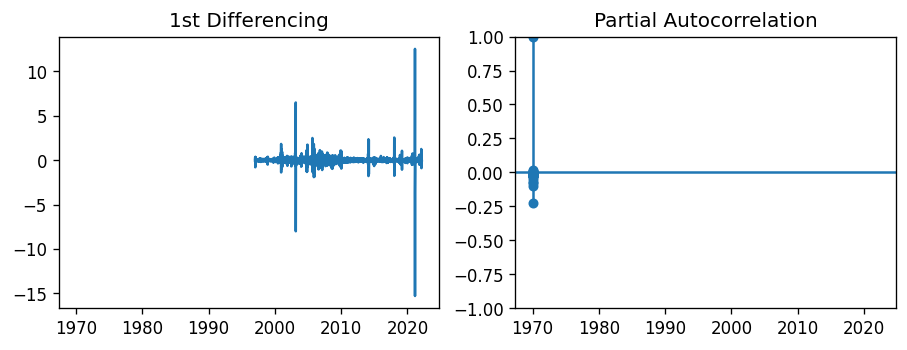

In [23]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(data.gas_price.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(data.gas_price.diff().dropna(), ax=axes[1])

plt.show()

#### Finding order of MA term (q)

> An MA term is technically, the error of the lagged forecast.

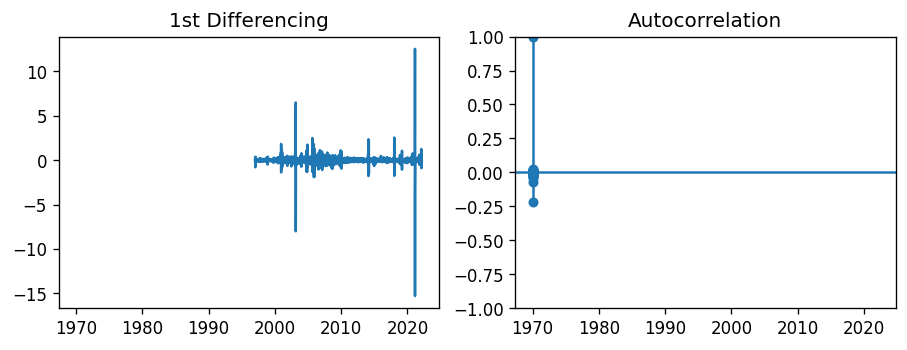

In [24]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)

axes[0].plot(data.gas_price.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(data.gas_price.diff().dropna(), ax=axes[1])

plt.show()

In [25]:
model = sm.tsa.arima.ARIMA(train, order = (1, 2, 1))
arima_model = model.fit() 
print(arima_model.summary())

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                               SARIMAX Results                                
Dep. Variable:              gas_price   No. Observations:                 5783
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -667.664
Date:                Mon, 25 Jul 2022   AIC                           1341.328
Time:                        11:21:14   BIC                           1361.315
Sample:                             0   HQIC                          1348.282
                               - 5783                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0093      0.002      5.188      0.000       0.006       0.013
ma.L1         -1.0000      0.036    -27.956      0.000      -1.070      -0.930
sigma2         0.0737      0.003     28.217      0.0

In [26]:
yp_train = arima_model.predict(start = 0, end = (len(train)-1))
yp_test = arima_model.predict(start = 0, end = (len(test)-1)) 

print("Train Data:\nMean Square Error: {}".format(mean_squared_error(train, yp_train)))
print("\nTest Data:\nMean Square Error: {}".format(mean_squared_error(test, yp_test)))

Train Data:
Mean Square Error: 0.07688605856171715

Test Data:
Mean Square Error: 3.8213615457397


In [27]:
print(yp_test)

date
1997-01-07    0.000000
1997-01-08    5.730000
1997-01-09    3.780000
1997-01-10    3.504207
1997-01-13    3.956606
                ...   
1999-02-22    1.786126
1999-02-23    1.766003
1999-02-24    1.745973
1999-02-25    1.725943
1999-02-26    1.635129
Name: predicted_mean, Length: 538, dtype: float64


In [28]:
print(test)

            gas_price
date                 
2020-01-07       2.17
2020-01-08       2.09
2020-01-09       2.05
2020-01-10       2.05
2020-01-13       2.03
...               ...
2022-02-23       4.59
2022-02-24       4.78
2022-02-25       4.63
2022-02-28       4.46
2022-03-01       4.36

[538 rows x 1 columns]


In [29]:
print(yp_train)

date
1997-01-07    0.000000
1997-01-08    5.730000
1997-01-09    3.780000
1997-01-10    3.504207
1997-01-13    3.956606
                ...   
2019-12-30    1.746469
2019-12-31    2.062591
2020-01-02    2.089982
2020-01-03    2.049321
2020-01-06    2.059790
Name: predicted_mean, Length: 5783, dtype: float64


In [30]:
print(train)

            gas_price
date                 
1997-01-07       3.82
1997-01-08       3.80
1997-01-09       3.61
1997-01-10       3.92
1997-01-13       4.00
...               ...
2019-12-30       2.06
2019-12-31       2.09
2020-01-02       2.05
2020-01-03       2.06
2020-01-06       2.10

[5783 rows x 1 columns]


### LSTM: Long Short Term Memory Model

In [31]:
slot = 15

x_train = []
y_train = []

for i in range(slot, len(train)):
    x_train.append(train.iloc[i-slot:i, 0])
    y_train.append(train.iloc[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
print(x_train.shape, y_train.shape)

(5768, 15, 1) (5768,)


In [32]:
lstm_model = tf.keras.Sequential()
lstm_model.add(tf.keras.layers.LSTM(units = 50, input_shape = (slot, 1), return_sequences = True, activation = 'relu'))
#lstm_model.add(tf.keras.layers.Dropout(0.01))
lstm_model.add(tf.keras.layers.LSTM(units = 50, activation = 'relu', return_sequences = True))
#lstm_model.add(tf.keras.layers.Dropout(0.01))
lstm_model.add(tf.keras.layers.LSTM(units = 50, return_sequences = True))
#lstm_model.add(tf.keras.layers.Dropout(0.01))
lstm_model.add(tf.keras.layers.LSTM(units = 50, return_sequences = False))
#lstm_model.add(tf.keras.layers.Dropout(0.01))
lstm_model.add(tf.keras.layers.Dense(units = 1))
lstm_model.compile(loss = 'mean_squared_error', optimizer = 'adam')

lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 15, 50)            10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 15, 50)            20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 15, 50)            20200     
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________


In [33]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 7)

history = lstm_model.fit(x_train, y_train, epochs = 100, 
                         batch_size = 64, 
                         verbose = 1, shuffle = False, 
                         callbacks = [early_stopping])

Epoch 1/100
91/91 [==============================] - 12s 64ms/step - loss: 2.9790
Epoch 2/100
91/91 [==============================] - 5s 60ms/step - loss: 2.6300
Epoch 3/100
91/91 [==============================] - 7s 73ms/step - loss: 2.5936
Epoch 4/100
91/91 [==============================] - 5s 60ms/step - loss: 2.3380
Epoch 5/100
91/91 [==============================] - 6s 63ms/step - loss: 2.0332
Epoch 6/100
91/91 [==============================] - 6s 63ms/step - loss: 1.5068
Epoch 7/100
91/91 [==============================] - 6s 63ms/step - loss: 1.0106
Epoch 8/100
91/91 [==============================] - 6s 64ms/step - loss: 0.6726
Epoch 9/100
91/91 [==============================] - 6s 67ms/step - loss: 0.4839
Epoch 10/100
91/91 [==============================] - 6s 66ms/step - loss: 0.4126
Epoch 11/100
91/91 [==============================] - 5s 60ms/step - loss: 0.3775
Epoch 12/100
91/91 [==============================] - 6s 63ms/step - loss: 0.3661
Epoch 13/100
91/91 [====

# Model Evaluation

### Train Data

In [34]:
yp_train = lstm_model.predict(x_train)
a = pd.DataFrame(yp_train)
a.rename(columns = {0: 'gp_pred'}, inplace = True); 
a.index = train.iloc[slot:].index
train_compare = pd.concat([train.iloc[slot:], a], 1)

In [35]:
train_compare.head(3)

,gas_price,gp_pred
date,,
1997-01-28,3.05,2.956889
1997-01-29,2.91,3.012775
1997-01-30,2.86,3.015507


In [36]:
train_compare.tail(3)

,gas_price,gp_pred
date,,
2020-01-02,2.05,2.100031
2020-01-03,2.06,2.110312
2020-01-06,2.10,2.121968


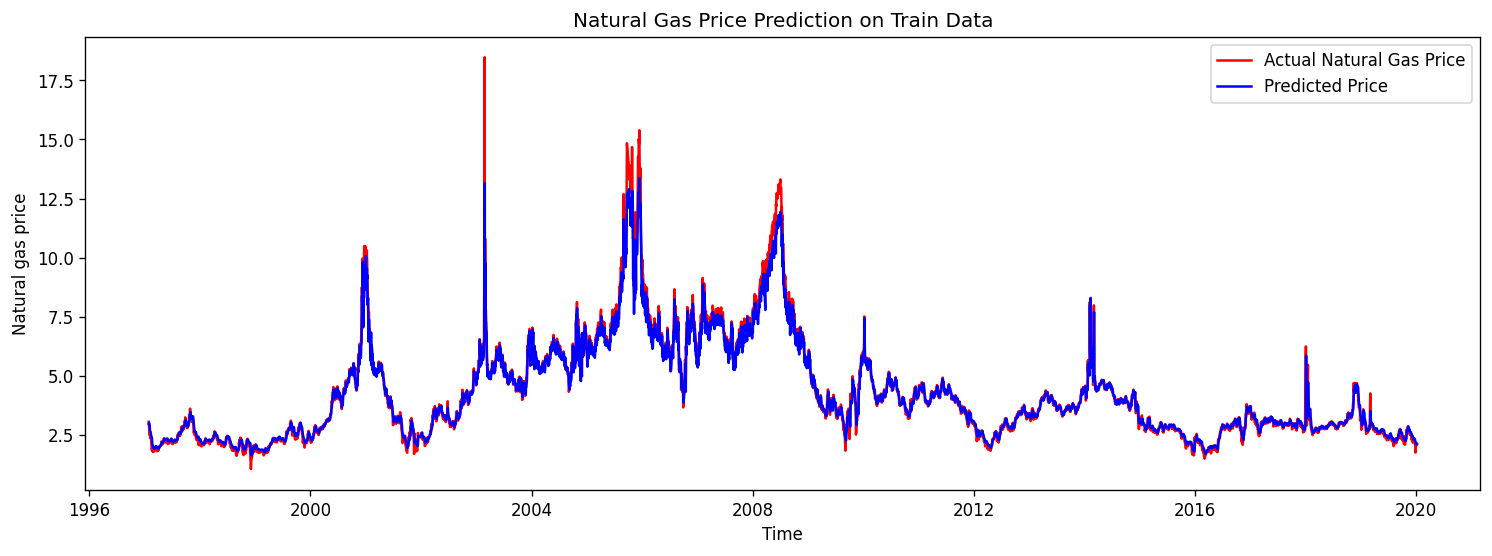

In [37]:
plt.figure(figsize = (15, 5))
plt.plot(train_compare['gas_price'], color = 'red', label = "Actual Natural Gas Price")
plt.plot(train_compare['gp_pred'], color = 'blue', label = 'Predicted Price')
plt.title("Natural Gas Price Prediction on Train Data")
plt.xlabel('Time')
plt.ylabel('Natural gas price')
plt.legend(loc = 'best')
plt.show()

### Test Data

In [38]:
dataset_total = pd.concat((train, test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test)- slot:].values
inputs = inputs.reshape(-1, 1)

x_test = []
y_test = []
for i in range (slot, len(test)+slot): #Test+15
    x_test.append(inputs[i-slot:i, 0])
    y_test.append(train.iloc[i, 0])
      
x_test, y_test = np.array(x_test), np.array(y_test)

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
pred_price = lstm_model.predict(x_test)

In [39]:
b = pd.DataFrame(pred_price)
b.rename(columns = {0: 'gp_pred'}, inplace = True); 
b.index = test.index
test_compare = pd.concat([test, b], 1)

In [40]:
test_compare.head(3)

,gas_price,gp_pred
date,,
2020-01-07,2.17,2.136256
2020-01-08,2.09,2.160694
2020-01-09,2.05,2.171263


In [41]:
test_compare.tail(3)

,gas_price,gp_pred
date,,
2022-02-25,4.63,4.720927
2022-02-28,4.46,4.621557
2022-03-01,4.36,4.463019


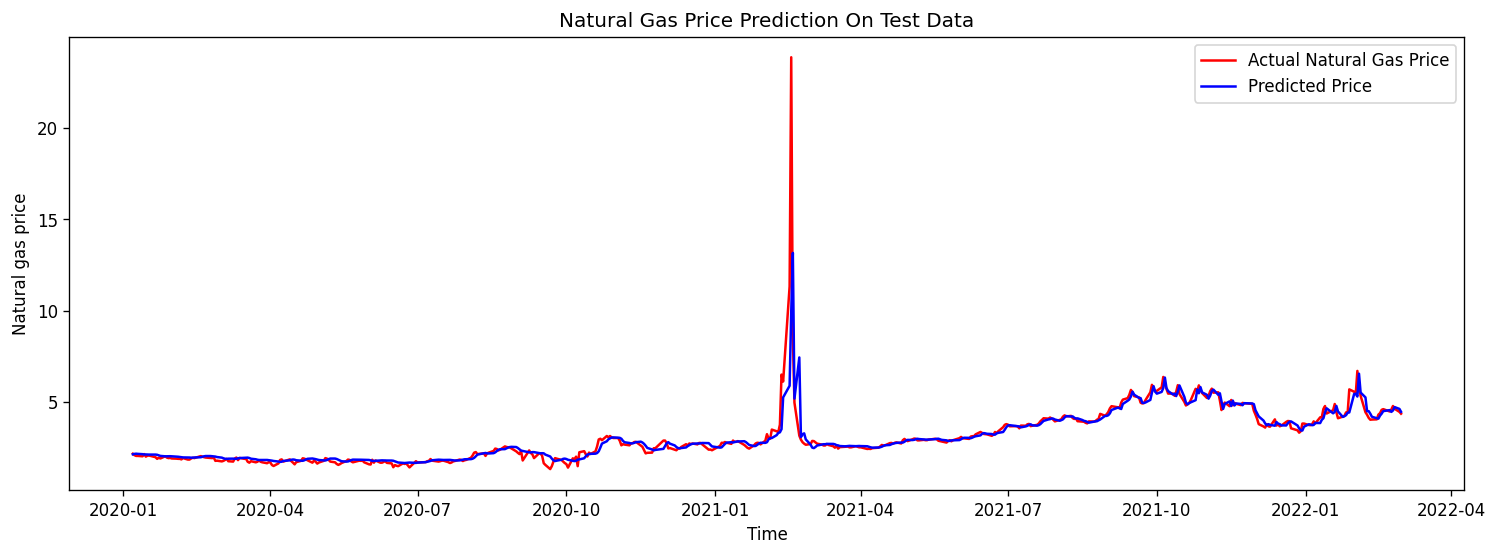

In [42]:
plt.figure(figsize = (15,5))
plt.plot(test_compare['gas_price'], color = 'red', label = "Actual Natural Gas Price")
plt.plot(test_compare['gp_pred'], color = 'blue', label = 'Predicted Price')
plt.title("Natural Gas Price Prediction On Test Data")
plt.xlabel('Time')
plt.ylabel('Natural gas price')
plt.legend(loc = 'best')
plt.show()

In [43]:
mse_train = mean_squared_error(train_compare['gas_price'], train_compare['gp_pred'])
mse_test = mean_squared_error(test_compare['gas_price'], test_compare['gp_pred'])

r2_train = r2_score(train_compare['gas_price'], train_compare['gp_pred'])
r2_test = r2_score(test_compare['gas_price'], test_compare['gp_pred'])

print("Train Data:\nMSE: {}\nR Square: {}".format(mse_train, r2_train))
print("\nTest Data:\nMSE: {}\nR Square: {}".format(mse_test, r2_test))

Train Data:
MSE: 0.11900485749986776
R Square: 0.9751169564001897

Test Data:
MSE: 0.549245798742061
R Square: 0.7775200333823367


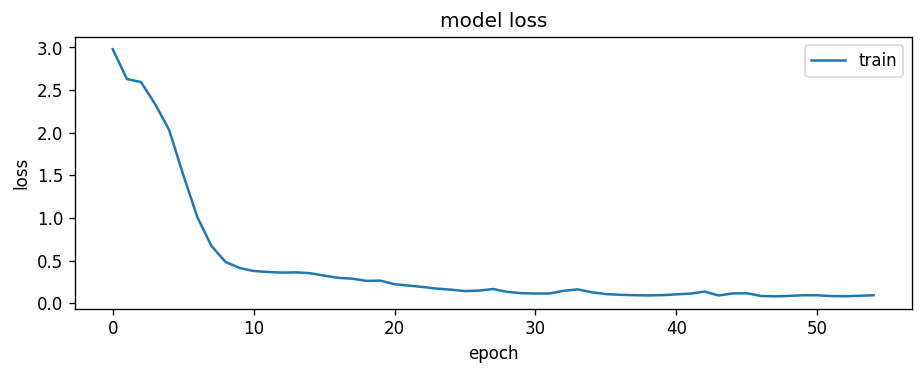

In [44]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.show()

# Forecasting for next 18 days

In [45]:
forecast = pd.DataFrame({'date': pd.date_range(start = '3/2/2022', end = '3/20/2022')}) # 2 March to 20 March 

inputs = test[len(test) - slot: ].values

for i in range(slot, len(forecast)): 
    inputs = inputs.T
    inputs = np.reshape(inputs, (inputs.shape[0], inputs.shape[1], 1))
    pred_price = lstm_model.predict(inputs[:,i-slot:i])
    inputs = np.append(inputs, pred_price)
    inputs = np.reshape(inputs, (inputs.shape[0], 1))

forecast['gp_pred'] = inputs
forecast = forecast.set_index('date')

In [46]:
forecast.reset_index(inplace = True)

fig = px.line(forecast, x = "date", y = "gp_pred", title = 'Natural Gas Price Forecasting', template = 'plotly_dark')
fig.show()

# Saving Model

In [47]:
train_compare.reset_index(inplace = True)
test_compare.reset_index(inplace = True)

df = pd.concat((train_compare[['date','gp_pred']], test_compare[['date', 'gp_pred']], forecast[['date', 'gp_pred']]), axis = 0)

In [48]:
df.head(3)

,date,gp_pred
0,1997-01-28,2.956889
1,1997-01-29,3.012775
2,1997-01-30,3.015507


In [49]:
df.tail(3)

,date,gp_pred
16,2022-03-18,4.402869
17,2022-03-19,4.425121
18,2022-03-20,4.435385


In [50]:
df.to_csv("predicted_price.csv", index = False)
lstm_model.save("lstm_model.h5")

# Do upvote if you find this Notebook useful... 😃